In [9]:
eta=0.01
epsilon=1e-5
maxiter=10000

In [11]:
library(googlesheets4)
library(lattice)
gs4_deauth()
sheet_data <- read_sheet("13CmIStaYtiQqR_dhBPrkHJINvVln9cepHypNinVQT3c")
x <- sheet_data[[1]]

✔ Reading from synthetic data.

✔ Range problem-2.



In [17]:
gradientDesc <- function(x, learn_rate, conv_threshold, max_iter) {
  # Initialize parameters
  n=length(x)
  mu <- 0    # Initial mu
  sigma <- 1 # Initial sigma
  theta <- c(mu, sigma) # Parameter vector [mu, sigma]
  
  # Initial negative log-likelihood
  loss <- sum(log(sigma) + (x - mu)^2 / (2 * sigma^2)) / n
  
  # Initialize history
  iterations <- 0
  loss_history <- numeric(max_iter)
  theta_history <- matrix(0, nrow = max_iter, ncol = 2)
  
  converged <- FALSE
  while (!converged) {
    # Compute gradients
    grad_mu <- sum(-(x - mu) / sigma^2) / n
    grad_sigma <- sum(1/sigma - (x - mu)^2 / sigma^3) / n
    grad <- c(grad_mu, grad_sigma)
    
    # Update parameters
    theta <- theta - learn_rate * grad
    mu <- theta[1]
    sigma <- theta[2]
    
    # Ensure sigma remains positive (optional, as problem allows unconstrained)
    if (sigma <= 0) sigma <- 1e-6  # Small positive value to avoid division by zero
    
    # Compute new loss
    loss_new <- sum(log(sigma) + (x - mu)^2 / (2 * sigma^2)) / n
    
    # Store history
    loss_history[iterations + 1] <- loss_new
    theta_history[iterations + 1, ] <- c(mu, sigma)
    
    # Check convergence based on gradient norm
    grad_norm <- sqrt(sum(grad^2))
    if (grad_norm < conv_threshold) {
      converged <- TRUE
      cat("Optimal parameters: mu =", mu, ", sigma =", sigma, "\n")
      cat("Iterations:", iterations, "\n")
      cat("Final Loss:", loss_new, "\n")
      break
    }
    
    # Update loss and iteration count
    loss <- loss_new
    iterations <- iterations + 1
    
    # Check max iterations
    if (iterations >= max_iter) {
      converged <- TRUE
      cat("Optimal parameters: mu =", mu, ", sigma =", sigma, "\n")
      cat("Iterations:", iterations, "\n")
      cat("Final Loss:", loss_new, "\n")
      break
    }
  }
  
  # Trim history
  loss_history <- loss_history[1:iterations]
  theta_history <- theta_history[1:iterations, ]
  
  # Return results
  return(list(theta = c(mu, sigma), loss = loss_new, iterations = iterations,
              loss_history = loss_history, theta_history = theta_history))
}

In [19]:
result=gradientDesc(x,eta,epsilon,maxiter)

Optimal parameters: mu = 0.05757294 , sigma = 1.037986 
Iterations: 917 
Final Loss: 0.5372823 


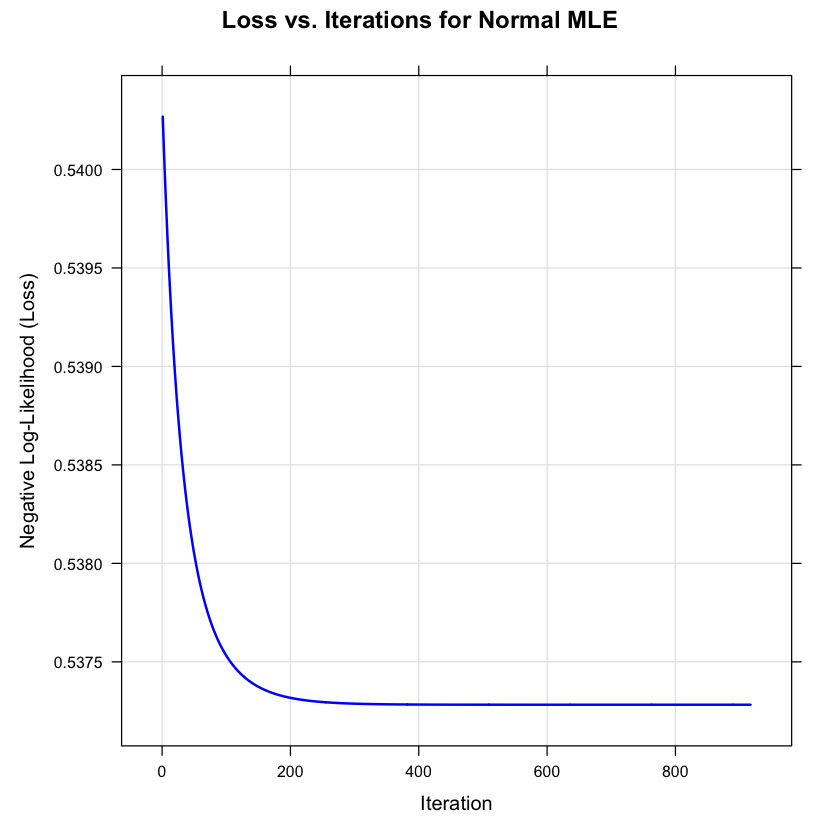

In [41]:
xyplot(
  result$loss_history ~ seq_along(result$loss_history),
  type = "l",
  xlab = "Iteration",
  ylab = "Negative Log-Likelihood (Loss)",
  main = "Loss vs. Iterations for Normal MLE",
  col = "blue",
  lwd = 2,
  grid = TRUE
)

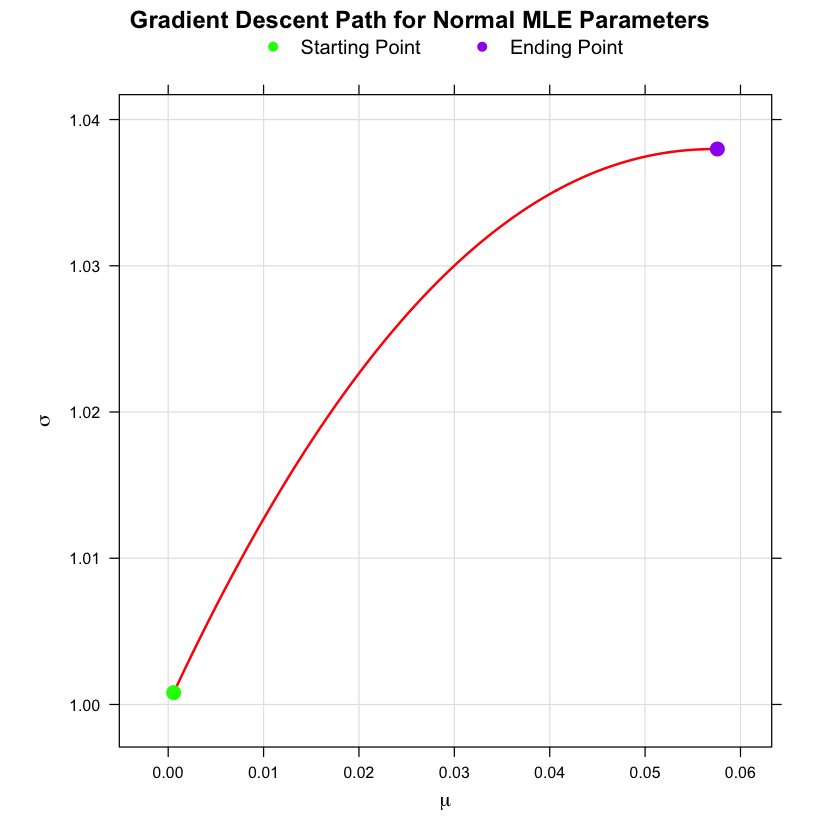

In [39]:
mu <- result$theta_history[,1]
sigma <- result$theta_history[,2]
mu_range <- range(mu, na.rm = TRUE)
sigma_range <- range(sigma, na.rm = TRUE)

# Add a 10% buffer to the ranges, ensure non-zero width
mu_buffer <- diff(mu_range) * 0.1
if (mu_buffer == 0) mu_buffer <- 0.1 # Minimum buffer for degenerate range
sigma_buffer <- diff(sigma_range) * 0.1
if (sigma_buffer == 0) sigma_buffer <- 0.1 # Minimum buffer for degenerate range

mu_limits <- c(mu_range[1] - mu_buffer, mu_range[2] + mu_buffer)
sigma_limits <- c(max(0, sigma_range[1] - sigma_buffer), sigma_range[2] + sigma_buffer) # Ensure sigma > 0

# 2. Path Plot of mu and sigma (updated with fixed scales)
xyplot(
  result$theta_history[,2] ~ result$theta_history[,1], # sigma vs. mu
  type = "l",
  xlab = expression(mu),
  ylab = expression(sigma),
  main = "Gradient Descent Path for Normal MLE Parameters",
  col = "red",
  lwd = 2,
  grid = TRUE,
  aspect = 1, # Square aspect ratio for balanced visualization
  scales = list(
    x = list(limits = mu_limits),
    y = list(limits = sigma_limits)
  ),
  panel = function(x, y, ...) {
    panel.xyplot(x, y, ...)
    # Add starting point
    panel.points(x[1], y[1], pch = 16, col = "green", cex = 1.5)
    # Add ending point
    panel.points(x[length(x)], y[length(y)], pch = 16, col = "purple", cex = 1.5)
  },
  key = list(
    space = "top",
    points = list(pch = c(16, 16), col = c("green", "purple")),
    text = list(c("Starting Point", "Ending Point")),
    columns = 2
  )
)
